<a href="https://colab.research.google.com/github/M-Chirag/Newswire-Analysis/blob/main/News_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:

#NLTK components
import nltk
# nltk.download('reuters')
# nltk.download('wordnet')
from nltk.corpus import reuters, stopwords
from nltk.probability import FreqDist
from nltk.stem.porter import *
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize

#Gensim components
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import models

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
#Plotting tools for LDA
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

import matplotlib.pyplot as plt
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis

import re
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import os
import string

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
#Pre-processing components
from multiprocessing import Process, freeze_support

from wordcloud import WordCloud
import matplotlib.colors as mcolors
import seaborn as sns

In [23]:
###Method to display the stats and necessary details of the reuters dataset
def stats_of_reuters():
    cats = reuters.categories()##Labels/categories present in the reuters dataset
    ##Reuters has 90 categories
    print("Reuters has %d categories/labels: \n%s" % (len(cats), cats))
    ###Read the reuters corpus
    print(reuters.readme())###This provides details about the reuters dataset, such as the creator and where it was used and other details
    print(len(reuters.raw()))##Displays the entire dataset news articles, separates each letter into a single character
    print(len(reuters.words()))###Words displays all the words that are present in the entire dataset, there are 1720901 words

In [24]:
###Method to visualize the frequency distribution of the  
def frequency_ditribution_of_words_in_reuters_corpus():
    reuters_words = reuters.words()
    freq_dist_reuters = FreqDist(reuters_words)
    ###It acts like a dictionary with the keys being the words and the count of those words
    print(freq_dist_reuters.keys())##The words/keys present
    freq_dist_reuters.plot(10)

In [25]:
###Method to separate the train and test documents from the reuters dataset
def separate_train_test_docs():
    reuters_document_ids = reuters.fileids()###Returns the file id's of the documents
    test_documents = [doc for doc in reuters_document_ids if doc.startswith("test/")]
    train_documents = [doc for doc in reuters_document_ids if doc.startswith("training/")]
    print("Reuters corpus has %d train documents: \n"%len(train_documents))
    print("Reuters corpus has %d test documents: \n"%len(test_documents))
    documents_dict = {}
    ###Adding the raw data, i.e. news contents of the train and test documents
    documents_dict["train_docs"] = [reuters.raw(document_id) for document_id in train_documents]
    documents_dict["test_docs"] = [reuters.raw(document_id) for document_id in test_documents]
    return train_documents, test_documents, documents_dict

In [26]:

###Method to check for the documents out of 21578 that are not added to train and test documents
def generate_bypassed_documents_list(train_documents, test_documents):
    total_list = []
    for doc_id in train_documents:###Getting only the id from the train documents list
        total_list.append(int(doc_id.split("/")[1]))
    for doc_id in test_documents:###Getting only the id from the test documents list
        total_list.append(int(doc_id.split("/")[1]))
    total_list.sort()##Sorting the id's to be able to determine the missing documents accurately
    missing_docs = []
    for i in range(21578):
        if i not in total_list:
            missing_docs.append(i)
    print("The missing documents are:")
    print(missing_docs)

In [27]:
###Method to check the number of documents related to one category and the raw data within those documents
def documents_related_to_category(category_str, check_single_or_all_docs):
    if check_single_or_all_docs:
        category_docs = reuters.fileids(categories=[category_str])
        print("{} of documents in category={}".format(len(category_docs),category_str))    
        document_id_cat = category_docs[0]###Getting the first document related to that category
        print(document_id_cat)
        document_words_cat = reuters.words(document_id_cat)##Getting the words present in that document
        print(document_words_cat)
        print(reuters.paras(fileids=[document_id_cat]))
    else:
        for i in reuters.categories():
            print("{} documents are included in the topic \"{}\"".format(len(reuters.fileids(i)),i))

In [28]:
###Method to pre-process the documents, i.e. convert to lowercase, remove punctuations, stopwords, perform stemming and lematization
def pre_processing(article):
    ###Initializing the stopwords corpus
    stop_words = stopwords.words('english')
    ###Initializing the stemmer
    stemmer = PorterStemmer()
    
    pre_processed_doc = []
    ###Gensim pre_process lowercases the words and then tokenizes the words
    for token in gensim.utils.simple_preprocess(article):
        if token not in stop_words and len(token)>3:
            stemmed_lematized_token = stemmer.stem(WordNetLemmatizer().lemmatize(token,pos='v'))
            pre_processed_doc.append(stemmed_lematized_token)
    
    ###To check the pre_processed result set this condition to True
    check_preprocess_result=False
    if check_preprocess_result:
        words = []
        for word in article:
            words.append(word)
        print(words)
        print('\n\n tokenized and lemmatized document: ')
        print(pre_processed_doc)
    return pre_processed_doc
   

Reuters has 90 categories/labels: 
['acq', 'alum', 'barley', 'bop', 'carcass', 'castor-oil', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'cotton', 'cotton-oil', 'cpi', 'cpu', 'crude', 'dfl', 'dlr', 'dmk', 'earn', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-oil', 'heat', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-oil', 'livestock', 'lumber', 'meal-feed', 'money-fx', 'money-supply', 'naphtha', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-oil', 'palmkernel', 'pet-chem', 'platinum', 'potato', 'propane', 'rand', 'rape-oil', 'rapeseed', 'reserves', 'retail', 'rice', 'rubber', 'rye', 'ship', 'silver', 'sorghum', 'soy-meal', 'soy-oil', 'soybean', 'strategic-metal', 'sugar', 'sun-meal', 'sun-oil', 'sunseed', 'tea', 'tin', 'trade', 'veg-oil', 'wheat', 'wpi', 'yen', 'zinc']

      The Reuters-21578 benchmark corpus, ApteMod vers

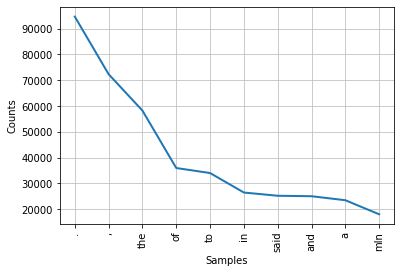

Reuters corpus has 7769 train documents: 

Reuters corpus has 3019 test documents: 

The missing documents are:
[0, 2, 3, 4, 7, 8, 15, 16, 17, 20, 21, 25, 26, 28, 31, 32, 33, 34, 35, 39, 43, 51, 52, 54, 55, 60, 61, 62, 63, 67, 70, 72, 73, 79, 84, 88, 90, 91, 107, 112, 114, 115, 116, 117, 118, 119, 120, 122, 131, 137, 141, 148, 149, 150, 154, 155, 156, 158, 159, 161, 170, 171, 172, 173, 174, 175, 177, 178, 181, 182, 184, 188, 190, 192, 195, 204, 205, 206, 207, 208, 215, 217, 218, 219, 222, 223, 224, 226, 230, 231, 234, 238, 239, 240, 243, 244, 245, 250, 251, 252, 255, 257, 258, 261, 262, 263, 264, 265, 266, 268, 269, 270, 276, 277, 278, 280, 282, 285, 286, 287, 288, 289, 291, 292, 294, 295, 300, 301, 305, 306, 308, 316, 318, 319, 321, 324, 325, 326, 328, 329, 333, 335, 337, 339, 340, 344, 347, 348, 350, 351, 355, 357, 358, 359, 360, 363, 364, 365, 367, 370, 373, 375, 380, 382, 384, 385, 386, 391, 394, 397, 403, 412, 413, 414, 415, 419, 421, 426, 427, 428, 429, 430, 431, 432, 433, 434, 4

In [31]:
if __name__ == '__main__':
    freeze_support()##This function is used because multiple core processing or multiple processes are executed at once
    
    #=============Stats and document separation and analysis stage===========
    
    ###Stats of reuters dataset
    stats_of_reuters()
     
    ##Computing the frequency distribution of the words in reuters, i.e. how many times each word occurs
    frequency_ditribution_of_words_in_reuters_corpus()
    
    ##Separate the train and test documents and create different set of documents of train and test
    train_documents, test_documents, documents_dict = separate_train_test_docs()
    
    ###checking the missing docs from 21578 docs
    check_for_missing_docs=True
    if check_for_missing_docs:
        generate_bypassed_documents_list(train_documents, test_documents)
    
    ###Category documents, to analyze the documents related to one category/label
    ###If true then check document for one category else check documents for all categories
    check_docs_related_to_one_category=True
    documents_related_to_category('coffee',check_docs_related_to_one_category)
    
    #=============Pre-processing stage===========
    preprocessed_documents = []
    for i in range(len(documents_dict["train_docs"])):
        preprocessed_documents.append(pre_processing(documents_dict["train_docs"][i]))
    for i in range(len(documents_dict["test_docs"])):
        preprocessed_documents.append(pre_processing(documents_dict["test_docs"][i]))

    #=============Dictionary===============
    ###Forming dictionary
    dictionary = gensim.corpora.Dictionary(preprocessed_documents)

    ###Check the top 10 items within the dictionary
    counter =0
    for key,value in dictionary.iteritems():
        print(key,value)
        counter+=1
        if counter>=10:
            break
    
    ##Filtering out tokens that appear in less than 15 documents or a certain fraction of documents and keep just 'n' most frequent tokens
    dictionary.filter_extremes(no_below=20,no_above=0.5,keep_n=100000)
    
    #==============Bag of words=============
    ###For each document creating a dictionary and the words that occur the most
    bag_of_words_corpus = [dictionary.doc2bow(document) for document in preprocessed_documents]
    print("Length of bag of words corpus:{} must equal the total number of documents".format(len(bag_of_words_corpus)))
    print("The first pre processed document")
    print(preprocessed_documents[0])
    print("Bag of words for the first document")
    print(bag_of_words_corpus[0])
    print("Length of bag of words for first document = {}".format(len(bag_of_words_corpus[0])))
    print("Length of bag of words for second document = {}".format(len(bag_of_words_corpus[1])))


    ###Checking the appearance of each word and count in the bag of words model for the first document
    bow_first_doc = bag_of_words_corpus[0]
    for i in range(len(bow_first_doc)):
        print("Word {} (\"{}\") appears {} time.".format(bow_first_doc[i][0],dictionary[bow_first_doc[i][0]],bow_first_doc[i][1]))
    
    #=============TF-IDF model==============
    ###Creating the TF-IDF model
    tfidf = models.TfidfModel(bag_of_words_corpus)##fitting thr tf idf model on the bag of words corpus
    corpus_tf_idf = tfidf[bag_of_words_corpus]

    
    ###Print the tf_idf vector for the first document
    for doc_tf_idf_vector in corpus_tf_idf:
        pprint(doc_tf_idf_vector)
        break

In [37]:
    
    #===================LDA==================
    #If true then LDA will be computed using bag of words corpus else using tfidf corpus
    compute_using_bag_of_words=True
    if compute_using_bag_of_words:
        ###Running LDA using bag of words
        #lda_final_model = gensim.models.ldamodel.LdaModel(bag_of_words_corpus, num_topics=10, id2word=dictionary, passes=50, chunksize=250,update_every=0,alpha='auto',iterations=50,minimum_probability=0.2)
        lda_final_model = gensim.models.LdaMulticore(bag_of_words_corpus, num_topics=10, id2word=dictionary, passes=50, chunksize=250,iterations=50,minimum_probability=0.2,workers=4)
    else:
        ###Running LDA using TF-IDF
        lda_final_model = gensim.models.LdaMulticore(corpus_tf_idf, num_topics=10, id2word=dictionary, passes=50, chunksize=250,iterations=50,minimum_probability=0.2,workers=4)    
    ###Save and load LDA model to save time
    #lda_final_model.save('lda.model')
    #lda_final_model = models.LdaMulticore.load('lda.model')
    print("The 10 topics and the top 10 words in each topic with weights")
    ten_topics=lda_final_model.print_topics(num_words=10)
    for topic in ten_topics:
        print(topic)
    
    ##words occuring in each topic with the weights to the words
    for idx, topic in lda_final_model.print_topics(-1):
        print('Topic: {} \nWords: {}'.format(idx, topic))
    
    ###Performance evaluation, i.e. to check which topic a document belongs to laong with the score/probability
    print("The first pre-processed document")
    print(preprocessed_documents[0])
    
    print("Checking the score as in to which topic this document belongs to")
    for index, score in sorted(lda_final_model[bag_of_words_corpus[0]], key=lambda tup: -1*tup[1]):
        print("\nScore: {}\t \nTopic: {}".format(score, lda_final_model.print_topic(index, 10)))
    

The 10 topics and the top 10 words in each topic with weights
(0, '0.115*"bank" + 0.027*"rate" + 0.023*"market" + 0.022*"money" + 0.019*"reserv" + 0.019*"billion" + 0.017*"central" + 0.016*"rat" + 0.014*"dealer" + 0.014*"week"')
(1, '0.089*"billion" + 0.075*"dlr" + 0.044*"year" + 0.024*"quarter" + 0.019*"earn" + 0.017*"first" + 0.016*"compani" + 0.016*"profit" + 0.014*"expect" + 0.014*"report"')
(2, '0.045*"tonn" + 0.026*"export" + 0.016*"wheat" + 0.015*"price" + 0.013*"year" + 0.013*"grain" + 0.012*"sugar" + 0.011*"crop" + 0.010*"coffe" + 0.010*"corn"')
(3, '0.033*"share" + 0.033*"compani" + 0.023*"dlr" + 0.017*"corp" + 0.016*"offer" + 0.014*"group" + 0.012*"stock" + 0.011*"acquir" + 0.010*"unit" + 0.010*"sell"')
(4, '0.056*"april" + 0.049*"stock" + 0.048*"dividend" + 0.043*"record" + 0.039*"share" + 0.027*"march" + 0.026*"split" + 0.025*"prior" + 0.022*"qtli" + 0.022*"set"')
(5, '0.025*"trade" + 0.021*"would" + 0.012*"offici" + 0.011*"japan" + 0.009*"govern" + 0.009*"state" + 0.009*"

In [38]:

    ###Visualize the LDA topics, words and distributions
    
    ###Visualization1: Topic and the words probability percentage belongong to that topic
    if compute_using_bag_of_words:
        lda_vizualization = gensimvis.prepare(lda_final_model,bag_of_words_corpus,dictionary,sort_topics=False)
        pyLDAvis.save_html(lda_vizualization,'LDA_visualization_bow.html')
    else:
        lda_vizualization = gensimvis.prepare(lda_final_model,corpus_tf_idf,dictionary,sort_topics=False)
        pyLDAvis.save_html(lda_vizualization,'LDA_visualization_tf_idf.html')

/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


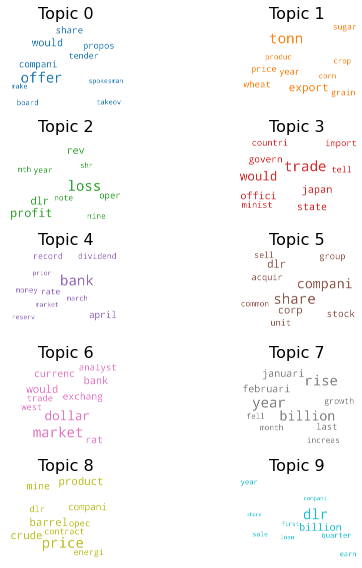

In [33]:

    
    ###Visualization2: Work cloud for top n keywords in each topic
    colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    cloud = WordCloud(stopwords=stopwords.words('english'),background_color='white',width=2500,height=1800,max_words=15,colormap='tab10',color_func=lambda *args, **kwargs: colors[i],prefer_horizontal=1.0)###Initialize the word cloud
    lda_topics = lda_final_model.show_topics(formatted=False)###Generate the 10 topics from LDA model
    fig, axes = plt.subplots(5, 2, figsize=(8,8), sharex=True, sharey=True)
    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)###Create one subplot for each topic
        topic_words_lda = dict(lda_topics[i][1])#retreive the words for each topic
        cloud.generate_from_frequencies(topic_words_lda, max_font_size=300)##check the frequency of occurence of each word in the wordcloud and display only 15 words
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

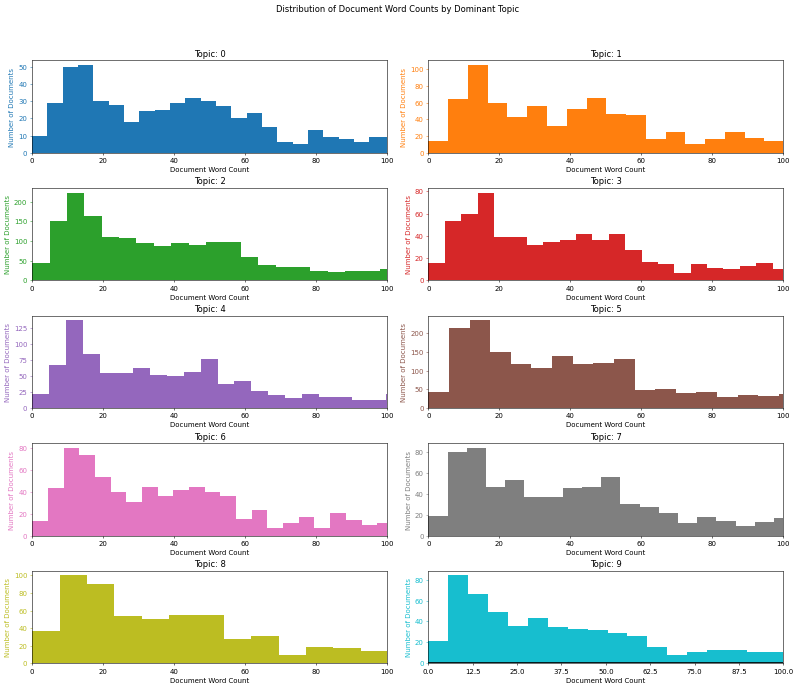

In [34]:
 
    
    ###Visualization3: Distribution of words in the documents for each topic
    document_topics_df = pd.DataFrame()
    ##get the main topic in each document
    for i,row_list in enumerate(lda_final_model[bag_of_words_corpus]):
        row = row_list[0] if lda_final_model.per_word_topics else row_list###Get the most likely topic for each word
        row = sorted(row, key=lambda x: (x[1]),reverse=True)
        #Get the dominanttopic, perc contribution and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:##dominant topic
                wp = lda_final_model.show_topic(topic_num)##Get the dominant topic
                topic_keywords = ", ".join([word for word, prop in wp])##Get the words in the topics
                document_topics_df = document_topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)##Combine the topic and the topic keywords
            else:
                break
    document_topics_df.columns = ['Dominant_Topic','Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(preprocessed_documents)
    document_topics_df = pd.concat([document_topics_df, contents], axis=1)#Combine the contents of each document along with the dominant topic
    document_topics_df = document_topics_df.reset_index()
    document_topics_df.columns = ['Document_No', 'Dominant_Topic', 'Keywords', 'Text']
    #print(document_topics_df.head(10))
    fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=50, sharex=False, sharey=False)
    colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    
    for i, ax in enumerate(axes.flatten()):
        df_dominant_topic_sub = document_topics_df.loc[document_topics_df.Dominant_Topic == i, :]
        doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
        ax.hist(doc_lens, bins = 100, color=colors[i])
        ax.tick_params(axis='y', labelcolor=colors[i], color=colors[i])
        sns.kdeplot(doc_lens, color="black", shade=False)
        ax.set(xlim=(0, 100), xlabel='Document Word Count')
        ax.set_ylabel('Number of Documents', color=colors[i])
        ax.set_title('Topic: '+str(i))    
    fig.tight_layout()
    fig.subplots_adjust(top=0.90)
    plt.xticks(np.linspace(0,100,9))
    fig.suptitle('Distribution of Document Word Counts by Dominant Topic')
    plt.show()

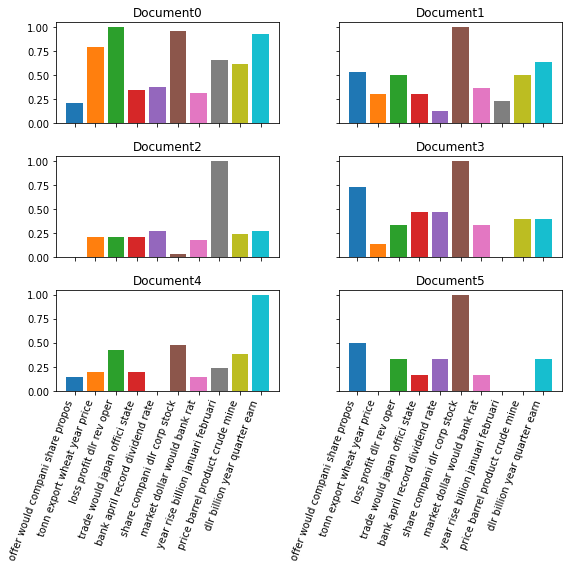

In [35]:
    ###Visualization4: Show the topic percentage for 6 documents
    ten_topics=lda_final_model.show_topics(formatted=False,num_words=30)##Retrieve the 10 topics of LDA and the top 30 words in each topic
    fig, axes = plt.subplots(3, 2, figsize=(8,8), sharex=True, sharey=True)
    colors = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        doc = preprocessed_documents[i]##Get the pre-processed document
        doc_topic_word_occurence = [0,0,0,0,0,0,0,0,0,0]###count the occurence of words that relate to each topic
        each_topic = ['a','a','a','a','a','a','a','a','a','a']
        for index,topic in ten_topics:#Iterate through each topic
            word_topic_list = [w[0] for w in topic]
            counter = 0
            for w in word_topic_list:##If the word in the topic is present in the document increase the counter value, i.e. add the number of occurence of the word in that document
                counter = counter + doc.count(w)
            doc_topic_word_occurence[index] = counter
            each_topic[index] = ' '.join(word_topic_list[:5])
        maxim = max(doc_topic_word_occurence)
        dist_list = [x/maxim for x in doc_topic_word_occurence]##To shrink the size the values are divided with the maximum occurence count
        positions = (0,1,2,3,4,5,6,7,8,9)
        labels = (each_topic[0],each_topic[1],each_topic[2],each_topic[3],each_topic[4],each_topic[5],each_topic[6],each_topic[7],each_topic[8],each_topic[9])
        fig.add_subplot(ax)
        ax.set_xticks(positions)
        ax.set_xticklabels(labels)
        plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')
        ax.bar([0,1,2,3,4,5,6,7,8,9],dist_list,color = colors[:10])
        ax.set_title("Document"+str(i))
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.tight_layout()
    plt.show()